# NLP : Sentiment Classification
Problem Statement - Classify the tweets by implementing any NLP approach for Sentiment analysis on the provided dataset. The objective is to recognize whether the given tweet is oriented as negative (-1), neutral (0), or positive (1) tone.

Overview: Sentiment analysis refers to identifying as well as classifying the sentiments that are expressed in the text source. Tweets are often useful in generating a vast amount of sentiment data upon analysis. These data are useful in understanding the opinion of the people about a variety of topics.

##Approach used :
1. Importing required libraries
2. Reading the dataset
3. Understanding the data as how it looks
4. Removing the records which has no label or text
5. Word Cloud ( Visualization)
6. Frequency of each sentiment - Bar plot 
7. Data Cleaning and Preprocessing 
a) Tokenization
b) Stopwords
c) Lemmatization and Stemming
d) Cleaning repetition, URLs, punctuation, numbers
8. Defining independent and dependent variable
9. Vectorization(TF-IDF) - Converting text into numbers for modelling
10. Train and test split
11. Defining evaluation function - confusion matrix
12. Modelling - Logistic Regression and Linear SVC
13. Performance evaluation - accuracy and F1 score



# Import Required Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Read and Load the dataset

In [3]:
df = pd.read_csv("Twitter_Data.csv")
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


# Exploratory Data Analysis

In [4]:
df.shape

(162980, 2)

###Output -
The data has 162980 text or sentences.
The data has two columns, one with text and other one labelling the sentiment of text - neutral, neg or positive

# Missing values

In [5]:
df.category.unique()

# -1 is negative
# 0 is neutral
# +1 is positive

array([-1.,  0.,  1., nan])

### Output -
The data has -1 (neg), 0(neu), 1(pos) and nan in category column, indicating that there are missing values in category column that needs to be treated.

In [6]:
df.isna().sum()


clean_text    4
category      7
dtype: int64

### Output -
This indicates that there are 4 rows in which text is missing and 7 rows in which sentiment label is missing.
The missing rows requires treatment

In [7]:
df[df['category'].isna()]


,clean_text,category
130448,the foundation stone northeast gas grid inaugu...,NaN
155642,dear terrorists you can run but you cant hide ...,NaN
155698,offense the best defence with mission shakti m...,NaN
155770,have always heard politicians backing out thei...,NaN
158693,modi government plans felicitate the faceless ...,NaN
159442,chidambaram gives praises modinomics,NaN
160559,the reason why modi contested from seats 2014 ...,NaN


In [8]:
df[df['clean_text'].isna()]


,clean_text,category
148,NaN,0.0
158694,NaN,-1.0
159443,NaN,0.0
160560,NaN,1.0


# Treating missing values
the rows with missing text/category are removed since there are total 11 rows which are quite less with the size of dataset and wouldnt impact the analysis or model building results

In [9]:
df.drop(df[df['clean_text'].isna()].index, inplace=True)
df.drop(df[df['category'].isna()].index, inplace=True)

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


# Data visualization of independent variable - text (Word cloud - frequency)

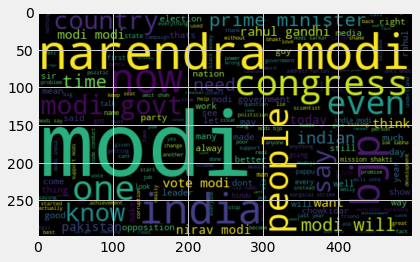

In [11]:
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#Plot the worldcloud
allwords = ''.join([twts for twts in df['clean_text']])
wordcloud = WordCloud(width=500,height=300, random_state=21,  max_font_size=119).generate(allwords)
plt.imshow(wordcloud, interpolation="bilinear")

# Data visualization of Target variable - Barplot (frequency chart)

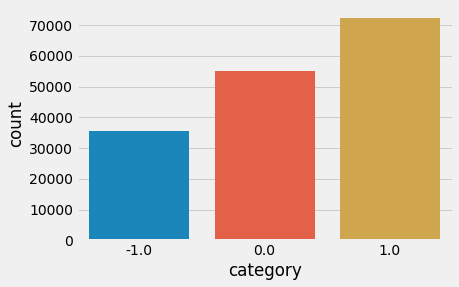

In [12]:
import seaborn as sns
sns.countplot(x='category', data=df)

### Output -
The positive sentiments are highest with count - 70000+, while neutral lies in the range of 50000-60000, and negative sentiment are quite less falling in the range of 30000-40000

# Data Preparation

In [13]:
data_pos = df[df['category'] == 1]
data_neg = df[df['category'] == 0]
data_neu = df[df['category'] == -1]

In [14]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]
data_neu = data_neu.iloc[:int(20000)]

In [15]:
dataset = pd.concat([data_pos, data_neg,data_neu])


In [16]:
dataset['clean_text']=dataset['clean_text'].str.lower()
dataset['clean_text'].tail()

92115                  sorry bro thought modi supporter \n
92119          modi full hate for muslims now and tell him
92123    modi shah modishah maker disastrously hopeless...
92139    country especially pakistan should turn blind ...
92143    this the power democracy you will not work for...
Name: clean_text, dtype: object

#1. Data Cleaning and NLTK Pre Processing
Since the text is very ambiguous, it needs a proper cleaning and normalization before training it to the model. The mornalization of text invloves following steps as mentioned below:

Tokenization 
Stop Words
Stemming
Lemmatization
Removing Repetition
Cleaning Punctuations, URLs and Numbers

#StopWords
Stopwords considered as noise in the text. Text may contain stop words such as is, am, are, this, a, an, the, etc.

In NLTK for removing stopwords, you need to create a list of stopwords and filter out your list of tokens from these words

In [17]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [18]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(clean_text):
    return " ".join([word for word in str(clean_text).split() if word not in STOPWORDS])
dataset['clean_text'] = dataset['clean_text'].apply(lambda text: cleaning_stopwords(text))
dataset['clean_text'].head()

2    say vote modi welcome bjp told rahul main camp...
3    asking supporters prefix chowkidar names modi ...
4    answer among powerful world leader today trump...
8    upcoming election india saga going important p...
9                                      gandhi gay modi
Name: clean_text, dtype: object

In [19]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(clean_text):
    translator = str.maketrans('', '', punctuations_list)
    return clean_text.translate(translator)
dataset['clean_text']= dataset['clean_text'].apply(lambda x: cleaning_punctuations(x))
dataset['clean_text'].tail()

92115                     sorry bro thought modi supporter
92119                          modi full hate muslims tell
92123    modi shah modishah maker disastrously hopeless...
92139    country especially pakistan turn blind eye atr...
92143    power democracy not work benefit society peopl...
Name: clean_text, dtype: object

In [20]:
def cleaning_repeating_char(clean_text):
    return re.sub(r'(.)1+', r'1', clean_text)
dataset['clean_text'] = dataset['clean_text'].apply(lambda x: cleaning_repeating_char(x))
dataset['clean_text'].tail()

92115                     sorry bro thought modi supporter
92119                          modi full hate muslims tell
92123    modi shah modishah maker disastrously hopeless...
92139    country especially pakistan turn blind eye atr...
92143    power democracy not work benefit society peopl...
Name: clean_text, dtype: object

In [21]:
def cleaning_URLs(df):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',df)
dataset['clean_text'] = dataset['clean_text'].apply(lambda x: cleaning_URLs(x))
dataset['clean_text'].tail()

92115                     sorry bro thought modi supporter
92119                          modi full hate muslims tell
92123    modi shah modishah maker disastrously hopeless...
92139    country especially pakistan turn blind eye atr...
92143    power democracy not work benefit society peopl...
Name: clean_text, dtype: object

In [22]:
def cleaning_numbers(df):
    return re.sub('[0-9]+', '', df)
dataset['clean_text'] = dataset['clean_text'].apply(lambda x: cleaning_numbers(x))
dataset['clean_text'].tail()

92115                     sorry bro thought modi supporter
92119                          modi full hate muslims tell
92123    modi shah modishah maker disastrously hopeless...
92139    country especially pakistan turn blind eye atr...
92143    power democracy not work benefit society peopl...
Name: clean_text, dtype: object

#Tokenization
It is the first and crucial step in text preprocessing. The breaking down of text into meaningful words is called word tokenization while breaking down of text into meaningful sentence is called sentence tokenization

In [23]:
from nltk.tokenize import RegexpTokenizer

In [24]:
tokenizer = RegexpTokenizer(r'\w+')

In [25]:
dataset['clean_text'] = dataset['clean_text'].apply(tokenizer.tokenize)
dataset['clean_text'].head()

2    [say, vote, modi, welcome, bjp, told, rahul, m...
3    [asking, supporters, prefix, chowkidar, names,...
4    [answer, among, powerful, world, leader, today...
8    [upcoming, election, india, saga, going, impor...
9                                  [gandhi, gay, modi]
Name: clean_text, dtype: object

#Stemming and Lemmatization
Stemming is faster as it chops the data without understanding the context of text, while lemmatization performs linguistically correct chopping of data with more accurate context.

Accuracy is more in lemmatization as stemming

Studies - Studi (Stemming) , Study (Lemmatization)

In [26]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['clean_text']= dataset['clean_text'].apply(lambda x: stemming_on_text(x))
dataset['clean_text'].head()

2    [say, vote, modi, welcome, bjp, told, rahul, m...
3    [asking, supporters, prefix, chowkidar, names,...
4    [answer, among, powerful, world, leader, today...
8    [upcoming, election, india, saga, going, impor...
9                                  [gandhi, gay, modi]
Name: clean_text, dtype: object

In [27]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    clean_text = [lm.lemmatize(word) for word in data]
    return data
dataset['clean_text'] = dataset['clean_text'].apply(lambda x: lemmatizer_on_text(x))
dataset['clean_text'].head()

2    [say, vote, modi, welcome, bjp, told, rahul, m...
3    [asking, supporters, prefix, chowkidar, names,...
4    [answer, among, powerful, world, leader, today...
8    [upcoming, election, india, saga, going, impor...
9                                  [gandhi, gay, modi]
Name: clean_text, dtype: object

# Defining X and Y
X -independent variable
Y - dependent variable

In [28]:
X=df.clean_text
y=df.category

# Train and test split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

#Tf-IDF Vectorization
One issue with simple counts(of words) is that some words like “the” will appear many times and their large counts will not be very meaningful in the encoded vectors.

An alternative is to calculate word frequencies, and by far the most popular method is called TF-IDF. This is an acronym than stands for “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word.

Term Frequency: This summarizes how often a given word appears within a document.

Inverse Document Frequency: This downscales words that appear a lot across documents.

The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents.

In [30]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  500000


In [31]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

# Defining function for Performance evaluation

In [32]:
def model_Evaluate(model):
  y_pred = model.predict(X_test)
# Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
# Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  #sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',  xticklabels = categories, yticklabels = categories)
  sns.heatmap(cf_matrix, annot = True, cmap = 'Blues',fmt = '',  xticklabels = categories, yticklabels = categories)
  
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# Model 1 - Logistic Regression

              precision    recall  f1-score   support

        -1.0       0.91      0.83      0.87      1801
         0.0       0.91      0.96      0.94      2669
         1.0       0.93      0.93      0.93      3679

    accuracy                           0.92      8149
   macro avg       0.92      0.91      0.91      8149
weighted avg       0.92      0.92      0.92      8149



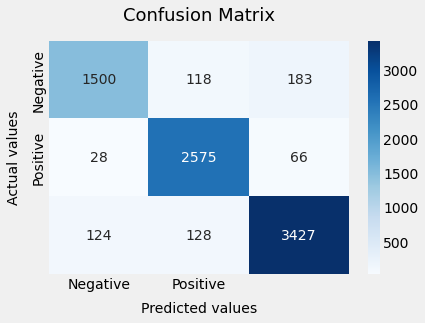

In [33]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)


# Model 2 - Linear Support Vector Classification

              precision    recall  f1-score   support

        -1.0       0.92      0.88      0.90      1801
         0.0       0.95      0.97      0.96      2669
         1.0       0.95      0.95      0.95      3679

    accuracy                           0.94      8149
   macro avg       0.94      0.93      0.94      8149
weighted avg       0.94      0.94      0.94      8149



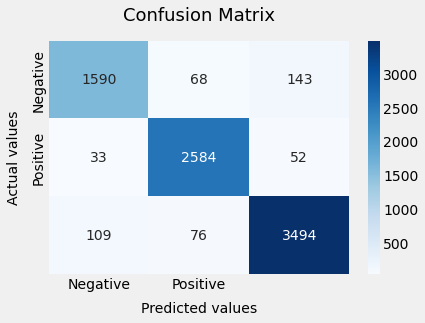

In [34]:
from sklearn.svm import LinearSVC, SVC

SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

#Performance Evaluation
Upon evaluating all the models we can conclude the following details i.e.

###Accuracy: 
As far as the accuracy of the model is concerned Logistic Support vector performs better than Logistic Regression

###F1-score: 
The F1 Scores for class 0, -1, 1 are :
(a) For class 0: SVM (accuracy =0.96) > Logistic Regression (accuracy = 0.94)
(b) For class 1: SVM (accuracy = 0.95) > Logistic Regression (accuracy = 0.93)
(c) For class -1: SVM (accuracy = 0.90) > Logistic Regression (accuracy = 0.87)

#Conclusion
Linear Support Vector turns out to be good model with 94% accuracy and is able to classify all the three class well